In [1]:
import os
from PIL import Image
import numpy as np
import json
import random
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
from matplotlib.pyplot import imshow
%matplotlib inline

def collapse(tensor):
  arr = np.zeros((30, 30))
  for x in range(30):
    for y in range(30):
      arr[x, y] = torch.argmax(tensor[x, y]).item()
  return arr

def visualize(tensor):
  #torch.argmax(tensor.reshape(30, 30, 11)).item()
  arr = np.zeros((30, 30))
  for x in range(30):
    for y in range(30):
      arr[x, y] = torch.argmax(tensor[x, y]).item()
  convert(arr)

def visualize2(tensor):
  arr = np.zeros((30, 30))
  for x in range(30):
    for y in range(30):
      difs = [torch.abs(v - tensor[x, y]) for v in color2vector]
      sums = [torch.sum(difs[i]) for i in range(11)]
      index_min = min(range(len(sums)), key=sums.__getitem__)
      #print(index_min)
      arr[x, y] = index_min
  convert(arr)

converter = {}
converter[0] = np.array([0, 0, 0])
converter[1] = np.array([0, 116, 217])
converter[2] = np.array([255, 65, 54])
converter[3] = np.array([46, 204, 64])
converter[4] = np.array([255, 220, 0])
converter[5] = np.array([170, 170, 170])
converter[6] = np.array([240, 18, 190])
converter[7] = np.array([255, 113, 27])
converter[8] = np.array([127, 219, 255])
converter[9] = np.array([135, 12, 37])
converter[10] = np.array([255, 255, 255])

def convert(X):
  Y = np.zeros(shape=(X.shape[0], X.shape[1], 3), dtype=np.uint8)
  for x in range(X.shape[0]):
    for y in range(X.shape[1]):
      Y[x, y] = converter[X[x, y]]
  imshow(Y)

In [3]:
class ARC_Task:
  def __init__(self, inputs, outputs, test_input, test_output):
    self.inputs = inputs
    self.outputs = outputs
    self.test_input = test_input
    self.test_output = test_output

In [4]:
class Encoder(nn.Module):
    
  def __init__(self, encoded_space_dim, latent_channels, fc2_input_dim):
    super().__init__()
    self.encoded_space_dim = encoded_space_dim
    self.latent_channels = latent_channels
    ### Convolutional section
    self.encoder_cnn = nn.Sequential(
      nn.Conv2d(11, 8, 3, stride=3, padding=0),
      nn.Sigmoid(),
      nn.Conv2d(8, latent_channels, 2, stride=2, padding=0),
      nn.Sigmoid(),
      )
        
    ### Flatten layer
    self.flatten = nn.Flatten(start_dim=1)
    ### Linear section
    self.encoder_lin = nn.Sequential(
      nn.Linear(25, 128),
      nn.Sigmoid(),
      nn.Linear(128, encoded_space_dim),
      nn.Sigmoid(), #?
    )
        
  def forward(self, x):
    x = self.encoder_cnn(x)
    x = self.flatten(x)
    x = self.encoder_lin(x)
    return x

In [5]:
class Decoder(nn.Module):
    
  def __init__(self, encoded_space_dim, latent_channels, fc2_input_dim):
    super().__init__()
    self.decoder_lin = nn.Sequential(
      nn.Linear(encoded_space_dim, 128),
      nn.Sigmoid(),
      nn.Linear(128, 25),
      nn.Sigmoid(),
    )

    self.unflatten = nn.Unflatten(dim=1, unflattened_size=(5, 5))

    self.decoder_conv = nn.Sequential(
      nn.ConvTranspose2d(latent_channels, 8, 2, stride=2, output_padding=0),
      nn.Sigmoid(),
      nn.ConvTranspose2d(8, 11, 3, stride=3, padding=0, output_padding=0),
      nn.Sigmoid(),
      )
        
  def forward(self, x):
    x = self.decoder_lin(x)
    x = self.unflatten(x)
    x = self.decoder_conv(x)
    return x

In [6]:
def run_model(encoder, decoder, task):
  task_vector = torch.zeros((encoder.latent_channels, encoder.encoded_space_dim))
  for input, output in zip(task.inputs, task.outputs):
    latent_input = encoder(input)
    latent_output = encoder(output)
    task_vector += latent_output - latent_input
  task_vector /= len(task.inputs)
  latent_prediction = encoder(task.test_input) + task_vector
  return decoder(latent_prediction)

In [7]:
def fetch(directory):
  data = []
  MAX_LENGTH = 30
  os.chdir(directory)
  files = [f for f in os.listdir() if f.endswith('json')]
  for f in files:
    with open(f, 'r') as file:
      json_file = json.loads(file.read())
      inputs = [one_hot_encode_3d(np.array(train_exmaples['input'])) for train_exmaples in json_file['train']]
      outputs = [one_hot_encode_3d(np.array(train_exmaples['output'])) for train_exmaples in json_file['train']]
      test_input = [one_hot_encode_3d(np.array(train_exmaples['input'])) for train_exmaples in json_file['test']]
      test_output = [one_hot_encode_3d(np.array(train_exmaples['output'])) for train_exmaples in json_file['test']]
      data.append(ARC_Task(inputs, outputs, test_input[0], test_output[0]))

  return data

def one_hot_encode_3d(array):
  MAX_LENGTH = 30
  arr = torch.zeros((MAX_LENGTH, MAX_LENGTH, 11))
  size = array.shape
  for x in range(MAX_LENGTH):
    for y in range(MAX_LENGTH):
      if x < size[0] and y < size[1]:
        arr[x, y, array[x, y]] = 1
      else:
        arr[x, y, 10] = 1
  return arr.reshape((11, MAX_LENGTH, MAX_LENGTH))

In [8]:
from torch.utils.data import Dataset

class ARCDataset(Dataset):
  def __init__(self, data):
    self.data = data

  def __getitem__(self, idx):
    return self.data[idx]

  def __len__(self):
    return len(self.data)

In [9]:
train_dataset = ARCDataset(fetch("/content/train"))
len(train_dataset)

400

In [10]:
encoder = Encoder(1000, 64, 11)
decoder = Decoder(1000, 64, 11)

test = torch.zeros((11, 30, 30))
decoder(encoder(test)).size()

torch.Size([11, 30, 30])

In [19]:
import torch.optim as optim

params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

mse = nn.MSELoss()
optimizer = optim.Adam(params_to_optimize, lr=0.001)
n_epochs = 500

for epoch in range(n_epochs):
  loss = 0

  for task in train_dataset:
    optimizer.zero_grad()
    prediction = run_model(encoder, decoder, task)
    train_loss = mse(prediction, task.test_output)
    train_loss.backward()
    optimizer.step()
    loss += train_loss.item()

  if epoch % 5 == 0:
    print(epoch, loss)

0 14.208398949354887
5 14.183537749573588
10 14.137932226061821
15 14.077800326049328
20 14.014493169263005
25 13.968134474009275
30 13.924794929102063
35 13.880168868228793
40 13.849314780905843
45 13.81660625897348
50 13.784624557942152
55 13.773213386535645
60 13.734656620770693
65 13.707917518913746
70 13.705536929890513
75 13.669458400458097
80 13.66284361667931
85 13.656144551932812
90 13.653981812298298
95 13.634077282622457
100 13.606381982564926
105 13.622757697477937
110 13.597785793244839
115 13.58326455950737
120 13.584886830300093
125 13.559455826878548
130 13.560670126229525
135 13.57849176414311
140 13.530362490564585
145 13.528093287721276
150 13.52284111827612
155 13.512674320489168
160 13.514520399272442
165 13.496240625157952
170 13.492938321083784
175 13.476351646706462
180 13.47384343482554
185 13.470944641157985
190 13.44725364819169
195 13.431783273816109
200 13.417410736903548
205 13.408242966979742
210 13.406826961785555
215 13.397522497922182
220 13.4055385868

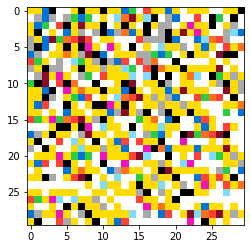

In [21]:
visualize(run_model(encoder, decoder, train_dataset[255]).reshape(30, 30, 11))

In [14]:
test_dataset = ARCDataset(fetch("/content/test"))
len(test_dataset)

400

In [20]:
# Compute MSE score
total_loss = 0
for task in test_dataset:
    prediction = run_model(encoder, decoder, task)
    train_loss = mse(prediction, task.test_output)
    total_loss += train_loss.item()
print(total_loss)

17.549375243484974
